# Module 1: **Baseline Simulator**

## 0.0 Ensure **Brian2** is installed.

In [ ]:
# Install Brian2 (necessary step if ran in Google Colab)
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.8 MB/s eta 0:00:00


## 0.1 Import all built-in packages.

In [2]:
# Import necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor, PopulationRateMonitor
from brian2 import ms, mV, Hz
from brian2 import defaultclock, run

## 0.2 Import model-validation specific package (MPR)
Note that the filename (of the data containing the parameters for validation) is currently defined/set inside the MPR-module.

In [3]:
# MPR-SNN Validation Module
import MPR

## 1.0 Simulate **MPR** of a given parameter set (from parameter_fit_index).

In [26]:
param_fit_index = 0

In [27]:
data_MPR = MPR.run_mpr(param_fit_index)

[10.  0.]


## 1.1 Store and save data dictionary (data_MPR)

One may opt to store the complete solution data. Alternatively, one can opt to store only the features that are comparable with SNN (firing rate, power spectra calculations).

For the moment, we store everything from data_MPR.

In [ ]:
# Save data_MPR as pickle file
file_name = 'data_MPR_' + str(param_fit_index) + '.pkl'
with open(file_name, 'wb') as fp:
     pickle.dump(data_MPR, fp)
     print('dictionary saved successfully to file')

dictionary saved successfully to file


## 1.2 Visualize data (firing rate, membrane potential, LFP, FFT PS)

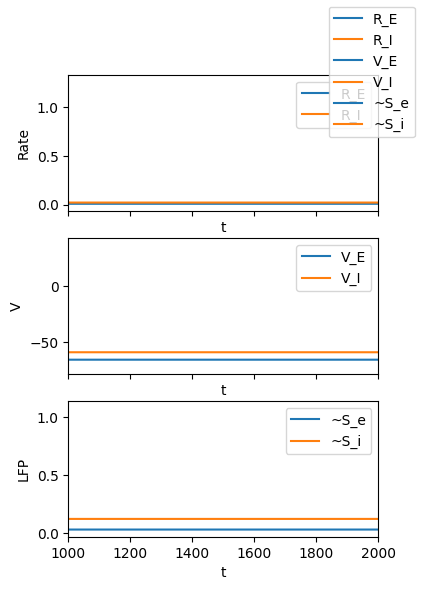

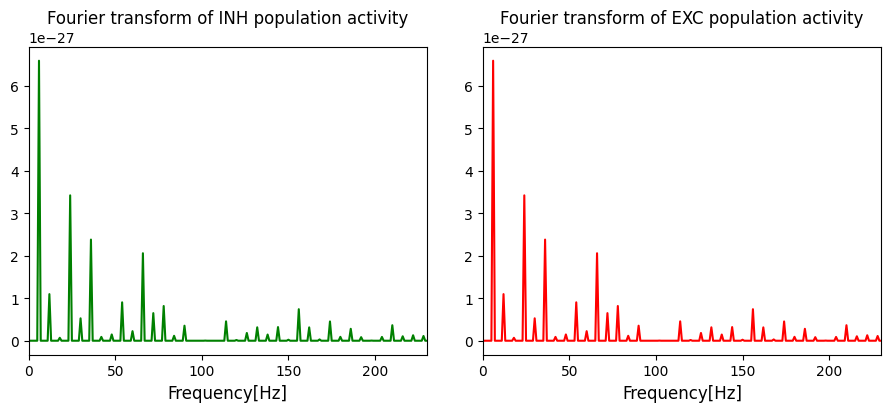

In [28]:
MPR.plot_mpr(data_MPR)
MPR.compute_frequency(data_MPR)

## 2.0 Simulate SNN counterpart.

Extract and store simulation parameters.

In [15]:
p = MPR.get_params(param_fit_index)

[10.  0.]


## 2.1 Declare network parameters

In [16]:
# numerical parameters
t_end = 2000
tfinal = t_end * ms
dt = 0.01
defaultclock.dt = dt * ms

# network parameters
networksize = 1000 #1000
Ne = int(p["cp_ee"] * networksize)
Ni = int((1-p["cp_ee"]) * networksize)

# ratio between excitatory and inhibitory neurons
cp_ee = p["cp_ee"]  # excitatory population ratio

a=p["a"]; b= p["b"]; c= p["c"]

# synaptic time scales
taue = p["sp_tause"]
taui = p["sp_tausi"]

# reversal potentials
Ee = p["sp_reve"]
Ei = p["sp_revi"]

# synaptic jump sizes to spikes (not very necessary))
sp_sejump = p["sp_sejump"]
sp_sijump = p["sp_sijump"]




## 2.2 Setup SNN Equations

In [17]:
# Setup the SNN Equations
eqs = """dv/dt = (a*v**2 + b*v + c - u + I + I_noise + cp_ee*sp_ge*se*(Ee-v) +  (1-cp_ee)*sp_gi*si*(Ei-v))/ms : 1
         du/dt = (alpha*(beta*v - u))/ms  : 1
         dse/dt = (-se*(1./taue))/ms : 1
         dsi/dt = (-si*(1./taui))/ms : 1
         I : 1
         I_noise : 1
         alpha : 1
         beta : 1
         gamma : 1
         ujump : 1
       """

## 2.3 Create network (given defined parameters, equations above)

In [18]:
# Instantiate Network
N = NeuronGroup(Ne + Ni, eqs, threshold="v>=50", reset="v = gamma; u += ujump", method="euler")
N.v = -65
N.se = 0
N.si = 0

N_exc = N[:Ne]
N_inh = N[Ne:]

## 2.4 Create instruments (spike monitoring, state-V, Population rate)

In [19]:
spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=[0, Ne], when='after_thresholds')
LFP_exc = PopulationRateMonitor(N_exc)
LFP_inh = PopulationRateMonitor(N_inh)

## 2.5 Subpopulation-specific parameters

In [20]:
N_exc.alpha = p["ep_alpha"]
N_exc.beta = p["ep_beta"]
N_exc.gamma = -85
N_exc.ujump = p["ep_ujump"]

N_inh.alpha = p["ip_alpha"]
N_inh.beta = p["ip_beta"]
N_inh.gamma = -85
N_inh.ujump = p["ip_ujump"]

N_exc.u = "beta*v"
N_inh.u = "beta*v"

N_exc.I_noise = p["ep_input"]
N_inh.I_noise = p["ip_input"]

sp_gi = p['sp_gi']
sp_ge = p['sp_ge']
ep_eta = p['ep_eta']
ip_eta = p['ip_eta']
ep_delta = p['ep_delta']
ip_delta = p['ip_delta']

In [21]:
N_exc.I = 'ep_eta + ep_delta*tan(pi*(2*(i+1) - Ne-1)/(2*(Ne+1)))'
N_inh.I = 'ip_eta + ip_delta*tan(pi*(2*(i+1) - Ni-1)/(2*(Ni+1)))'

## 2.6 Construct Connections

In [22]:
Ce = Synapses(N_exc, N, on_pre='se+=sp_sejump/N_incoming')
Ci = Synapses(N_inh, N, on_pre='si+=sp_sijump/N_incoming')
Ce.connect(p=1)
Ci.connect(p=1)

## 3.0 Execute simulation

In [23]:
run(tfinal)

## 3.1 Compute power spectra

In [24]:
#Fourier Analysis
time_lowerbound =  t_end-1000 ; time_upperbound = t_end
ttt = dt / 1000  #0.01ms is time resolution for signal


# Rate of INH population
signal_inh = np.array(LFP_inh.smooth_rate(window='gaussian', width=1*ms)/Hz)[int(time_lowerbound/dt):int(time_upperbound/dt)]
FFT_signal_inh = np.fft.fft(signal_inh)
power_spectrum_inh = np.abs(FFT_signal_inh)**2
freq_inh = np.fft.fftfreq(power_spectrum_inh.size , d=ttt)
positive_freq_indices_inh = freq_inh > 0
frequencies_inh = freq_inh[positive_freq_indices_inh]
power_spectrum_inh = power_spectrum_inh[positive_freq_indices_inh]

# Rate of EXC population
signal_exc = np.array(LFP_exc.smooth_rate(window='gaussian', width=1*ms)/Hz)[int(time_lowerbound/dt):int(time_upperbound/dt)]
FFT_signal_exc = np.fft.fft(signal_exc)
power_spectrum_exc = np.abs(FFT_signal_exc)**2
freq_exc = np.fft.fftfreq(power_spectrum_exc.size , d=ttt)
positive_freq_indices_exc = freq_exc > 0
frequencies_exc = freq_exc[positive_freq_indices_exc]
power_spectrum_exc = power_spectrum_exc[positive_freq_indices_exc]

## 3.2 Visualize trajectories and power spectra

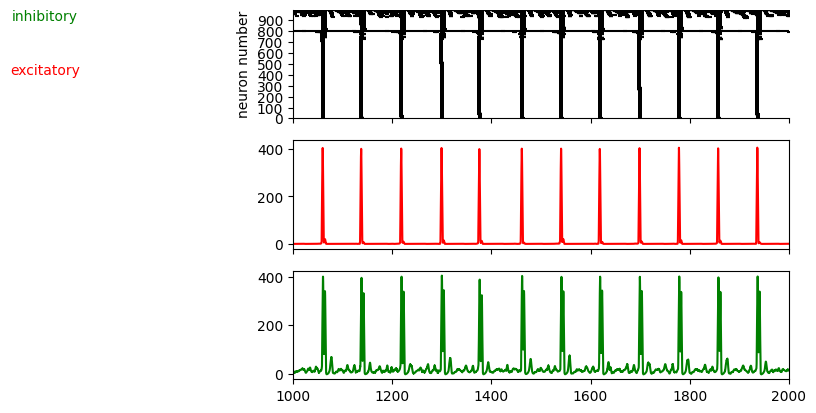

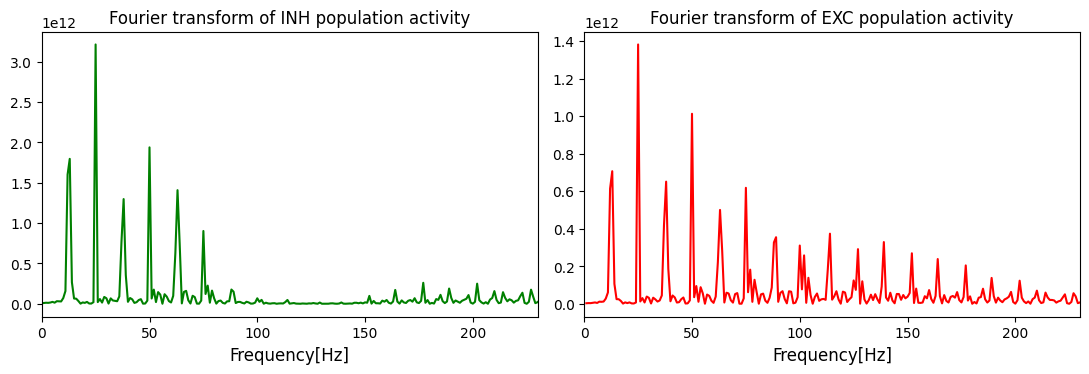

In [25]:
# visualization part 1
fig, (ax, ax_rate_exc, ax_rate_inh) = plt.subplots(3, 1, sharex=True)

ax.scatter(spikemon.t / ms, spikemon.i[:], marker="_", color="k", s=10)


ax.set_xlim(100, tfinal / ms)
ax.set_ylim(0, len(N))
ax.set_ylabel("neuron number")
ax.set_yticks(np.arange(0, len(N), 100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(Ne, color="k")
ax.text(500, 900, 'inhibitory', backgroundcolor='w', color='green', ha='center')
ax.text(500, 400, 'excitatory', backgroundcolor='w', color='red', ha='center')

# ax_rate.plot(LFP_exc.t/ms, LFP_exc.rate/Hz)
ax_rate_exc.plot(LFP_exc.t/ms, LFP_exc.smooth_rate(window='gaussian', width=1*ms)/Hz,
                 color = 'red', label = 'Exc')

# ax_rate_inh.plot(LFP_inh.t/ms, LFP_inh.rate/Hz, color = 'red', label = 'Exc')
ax_rate_inh.plot(LFP_inh.t/ms, LFP_inh.smooth_rate(window='gaussian', width=1*ms)/Hz,
                 color = 'green', label = 'Inh')
ax_rate_inh.set_xlim(t_end - 1000, t_end)

# fig2, (ax_exc, ax_inh) = plt.subplots(2, 1, sharex=True)
# ax_exc.plot(statemon.t / ms,  statemon.v[0], color = 'red', label = 'Exc')
# ax_inh.plot(statemon.t / ms,  statemon.v[1], color = 'green', label = 'Inh')
# ax_inh.set_xlabel('Time (ms)')

# visualization part 2
Fig=plt.figure(figsize=(11,4))
plt.subplots_adjust(hspace=0.3, wspace=0.14)

figa=Fig.add_subplot(121)
plt.title('Fourier transform of INH population activity', fontsize=12)
plt.plot(frequencies_inh , power_spectrum_inh , c='green')
plt.xlim(0,230)
plt.xlabel('Frequency[Hz]' , fontsize=12)

figa=Fig.add_subplot(122)
plt.title('Fourier transform of EXC population activity', fontsize=12)
plt.plot(frequencies_exc , power_spectrum_exc , c='red')
plt.xlim(0,230)
plt.xlabel('Frequency[Hz]' , fontsize=12)
plt.tight_layout()
plt.show()

## 4.0 Extract relevant simulation data (spike trace, LFP, power spectra)

In [ ]:
list_spike_t = spikemon.t / ms
list_spike_ID = spikemon.i[:]

list_LFP_exc_t = LFP_exc.t/ms
list_LFP_exc_f = LFP_exc.smooth_rate(window='gaussian', width=1*ms)/Hz

list_LFP_inh_t = LFP_inh.t/ms
list_LFP_inh_f = LFP_inh.smooth_rate(window='gaussian', width=1*ms)/Hz

In [ ]:
list_fw_exc, list_fA_exc = frequencies_exc, power_spectrum_exc
list_fw_inh, list_fA_inh = frequencies_inh, power_spectrum_inh

## 4.1 Store simulation data in a dictionary (data_SNN)

In [ ]:
data_SNN = {'parameters' : p,
            'N' : networksize,
            't_end' : t_end,
            't_lowerbound' : time_lowerbound,
            't_upperbound' : time_upperbound,
            'spike_t' : list_spike_t,
            'spike_ID' : list_spike_ID,
            'LFP_exc_t' : list_LFP_exc_t,
            'LFP_exc_f' : list_LFP_exc_f,
            'LFP_inh_t' : list_LFP_inh_t,
            'LFP_inh_f' : list_LFP_inh_f,
            'fw_exc' : list_fw_exc,
            'fA_exc' : list_fA_exc,
            'fw_inh' : list_fw_inh,
            'fA_inh' : list_fA_inh,
            }

## 4.2 Save dictionary as Pickle file.

In [ ]:
file_name = 'data_SNN_' + str(param_fit_index) + '.pkl'
with open(file_name, 'wb') as fp:
     pickle.dump(data_SNN, fp)
     print('dictionary saved successfully to file')

dictionary saved successfully to file
